In [ ]:
#!pip install mediapipe opencv-python

In [8]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [2]:
def calc_angle(a,b,c): # angle between 3 points
    a = np.array(a) # first joint
    b = np.array(b) # mid joint
    c = np.array(c) # end joint
    
    radian = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radian*180.0/np.pi)
    
    if angle > 180.0:
        angle = 360 - angle
        
    return angle

In [12]:
def recognise_situp(detection):
    
    global counter
    global state
    global feedback
    global range_flag
    global halfway
    global body_angles
    global knee_angles
    
    try: 
        landmarks = detection.pose_landmarks.landmark
        
        left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
        left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
        left_heel = [landmarks[mp_pose.PoseLandmark.LEFT_HEEL.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HEEL.value].y]
        left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]

        # CALCULATE ANGLES 
        angle_knee = calc_angle(left_hip, left_knee, left_heel)
        angle_body = calc_angle(left_shoulder, left_hip, left_knee)
        knee_angles.append(int(angle_knee))        
        body_angles.append(int(angle_body))        

      
        if ((angle_body<80 and angle_body>50) and state == "Down"): #Half-way there (Used for checking bad situps)
            halfway = True
#             feedback = "Halfway there!"

        if (angle_body<40 and state == "Down"): #Complete situp
            state = "Up"
            range_flag = True
#             feedback = "All the way Up!"
            
        if (angle_body>90 and angle_knee<60): #Resting position;to check if situp was done properly
            state = "Down"
            
            if halfway: #Check if a rep was attempted
                if range_flag: #Check if a proper rep was performed
                    counter += 1
                    feedback = "Good repetition!"
                else:
                    feedback = "Did not perform sit up completely."
                range_flag = False #Reset vars
                halfway = False
                
        if (angle_knee>70): #Triggers anytime the legs are not tucked in
            feedback = "Keep legs tucked in closer"

    except: 
        pass


In [16]:
cap = cv2.VideoCapture(0) 

counter = 0
state = None
feedback = None
range_flag = True
halfway = False

WIDTH = 10000
HEIGHT = 10000

frame_count = 0
# Plotting variables
frames = []
body_angles = []
knee_angles = []

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose: # accuracy 
    while cap.isOpened():
        ret,frame = cap.read() 
        frame_count += 1
        frames.append(frame_count)
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) 
        image.flags.writeable = False 
        
        detection = pose.process(image) 
        
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
        
        #Functions
        ####
        recognise_situp(detection)
        ####
        
        cv2.rectangle(image, (0,0), (635,73), (245,117,16), -1) 
        
        # Rep data
        cv2.putText(image, "REPS:", (15,12), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA) # font, size, color, line width, line type
        
        cv2.putText(image, str(counter), (10,70),
                   cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 2, cv2.LINE_AA)
        
        # Stage data
        cv2.putText(image, "STATE:", (100,12), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA) 
        
        cv2.putText(image, state, (110,70),
                   cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 2, cv2.LINE_AA)
        
        cv2.putText(image, "FEEDBACK:", (300,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
            
        cv2.putText(image, feedback, (320,70), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 2, cv2.LINE_AA)
        
        mp_drawing.draw_landmarks(image, detection.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                 mp_drawing.DrawingSpec(color=(0,0,255),thickness=2, circle_radius=2), 
                                  mp_drawing.DrawingSpec(color=(0,255,0),thickness=2, circle_radius=2) 
                                 )
        
        '''
        cv2.rectangle(image, (0,0), (width, int(height*0.1)), (245,117,16), -1)
        cv2.putText(image, "REPS:", (int(width*0.01), int(height*0.025)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA) # font, size, color, line width, line type
        
        cv2.putText(image, "STAGE:", (int(width*0.1), int(height*0.025)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        
        cv2.putText(image, "FEEDBACK:", (int(width*0.2), int(height*0.025)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        
        cv2.putText(image, str(counter), (int(width*0.01), int(height*0.08)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
        cv2.putText(image, stage, (int(width*0.1), int(height*0.08)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
        cv2.putText(image, feedback, (int(width*0.2), int(height*0.08)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        '''
        window_name = 'Sit-up Counter'
        
        cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
        cv2.imshow(window_name, image)

        if cv2.waitKey(10) & 0xFF == ord("q"): 
            break

    cap.release() 
    cv2.destroyAllWindows()

In [14]:
# initialise variables
counter = 0
state = 'Down'
range_flag = True
feedback = ''
frame_count = 0
# Plotting variables
frames = []
body_angles = []
knee_angles = []


feed = cv2.VideoCapture(0)

# Get user's maximum resolution
WIDTH = 10000
HEIGHT = 10000
feed.set(cv2.CAP_PROP_FRAME_WIDTH, WIDTH)
feed.set(cv2.CAP_PROP_FRAME_HEIGHT, HEIGHT)
width = int(feed.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(feed.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Mediapipe Pose model instance
with mp_pose.Pose(min_detection_confidence=50, min_tracking_confidence=50) as pose:
    while feed.isOpened():
        ret, frame = feed.read()
        frame_count += 1
        frames.append(frame_count)
        # Mirror frame
        frame = cv2.flip(frame, 1)
        # Recolor image from BGR to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        
        # Pose detection
        detection = pose.process(image)
        # Recolor image from RGB back to BGR
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = True

        # Render detections
        mp_drawing.draw_landmarks(image, detection.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))
        
        # Recognise particular exercise [REPLACABLE]
        recognise_situp(detection)

        # Status box setup
        cv2.rectangle(image, (0,0), (width, int(height*0.1)), (245,117,16), -1)
        cv2.putText(image, "REPS:", (int(width*0.01), int(height*0.025)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA) # font, size, color, line width, line type
        
        cv2.putText(image, "STATE:", (int(width*0.1), int(height*0.025)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        
        cv2.putText(image, "FEEDBACK:", (int(width*0.2), int(height*0.025)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        
        cv2.putText(image, str(counter), (int(width*0.01), int(height*0.08)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
        cv2.putText(image, state, (int(width*0.1), int(height*0.08)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
        cv2.putText(image, feedback, (int(width*0.2), int(height*0.08)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
        window_name = 'Exercise Counter'
        
        cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
        cv2.imshow(window_name, image)
        
        # quit webcam
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cv2.destroyAllWindows()
cv2.waitKey(1)
feed.release()


ValueError: x and y must have same first dimension, but have shapes (103,) and (95,)

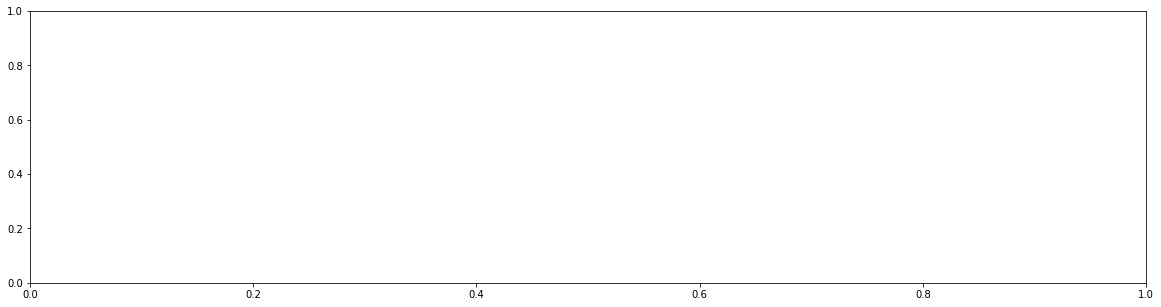

In [17]:
plt.rcParams["figure.figsize"] = (20,5)
fig, ax = plt.subplots()

ax.plot(frames, body_angles, '-', color = 'red', label = 'Body Angle')
# ax.plot(frames, knee_angles, '-', color = 'blue', label = 'Knee Angle')
ax.axhline(y=30, color='g', linestyle='--')
ax.legend(loc = 'center left')
ax.set_xlabel('Frames')
ax.set_ylabel('Angle')

print(f'You managed {counter} repetitions!')